# Linear Regression and SVC
## Notebook Objectives:
* read in the sample data
* create an Linear Regression model
    * plot the results
* create an Linear Regression model with multiple variables
* create an SVC model with a categorical variable
    * plot the results
* calcualte the confusion matrix

### Importing Packages
This cell is used to set up the project by importing required packages

In [29]:
import numpy as np
from scipy import stats
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
import matplotlib.pyplot as plt

### Loading Data
Here, a relative file path is used to reference a csv file containing the data needed.  
The data comes from a study of Gamma-Ray Bursts. While I have seen this dataset before, (hence the reason I thought it would be a good candidate for this project) I have not done this analysis or any work with it before. 
#### Data Summary
The file is a table of Gamma-Ray Burst Pulse properties. It consists of categorical data, such as the identification of short pulses, and quantitative data, which includes properties like pulse lag, asymmetry and duration. Here, the work will be focused on four main columns of the data:
* `class` - categorical classificaiton
* `log10(duration)` - the pre calculated log of a pulse's duration
* `log10(S)` - the pre calculated log of the spectral lag of a pulse
* `asymmetry` - a value representing the pulses asymmetry

In [30]:
# for header reference
# headers = ['burst','class','3 class','complete','duration','sig_dur','sig_asym','sig_lag','pulse pk flux','sig_pk flux','S(1+2+3)','sigS(1+2+3)','hr31 (erg)','sig hr31 (erg)','log10(dur)','asymmetry','lag','log10(p256)','log10(S)','log10(hr31)']

# init an empty list (I had a lot of trouble with the np.genfromtext module and the different data types in the data,
# so I built a numpy array manually)
data = []
# open and read the csv line-by-line
import csv
with open('../data/project_two/2010 GRB pulse table.csv', newline='\n') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader)
    for row in reader:
        data.append(np.asarray(row))
# build the numpy array
data = np.asarray(data)

## Defining the data
A distinction between test and training data

In [31]:
# separate out test and training data
training_data = data[:700,:]
test_data = data[701:,:]

# define training data variables
X1 = training_data[:,14].astype(np.float32) # log10(dur)
X2 = training_data[:,15].astype(np.float32) # asymmetry
Y = training_data[:,18].astype(np.float32) # log10(lag)
X = training_data[:,14:16].astype(np.float32) # log10(duration) and asymmetry

# define test data variables
Y_test = test_data[:,18].astype(np.float32)
X_test = test_data[:,14:16].astype(np.float32) # log10(duration) and asymmetry

## Linear Regression
Here the linear regression model is calculated and applied using scipy's [stats.linregress](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html) module, creating a prediciton for `log10(lag)` off of `log10(duration)`

In [32]:
# calculate the linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(X1,Y)
# apply the model
Yhat = intercept + slope*X1
print( "Yhat = {0:0.2f} + {1:0.2f}X1".format( intercept, slope ) )
print( "r value = {0:0.2f}".format( r_value ) )

Yhat = -6.68 + 0.53X1
r value = 0.61


## Plotting the linear model 

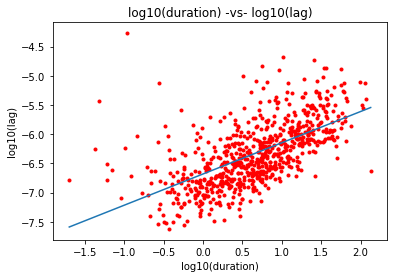

In [33]:
# create lines for plotting
Xp = np.linspace( np.min(X1), np.max( X1 ) )
Yline = intercept + slope*Xp

# plot the results
plt.figure()
plt.plot( Xp, Yline )
plt.title( "log10(duration) -vs- log10(lag)")
plt.scatter( X1, Y, color='red', marker='.' )
plt.xlabel( "log10(duration)" )
plt.ylabel( "log10(lag)" )
plt.show()

## Linear Regression with Multiple Variables
Here, linear regression is calculated again, except this time, we are using multiple variables - `log10(duration)` and `asymmetry` - to predict `log10(lag)`

In [34]:
# calculate the multivariate linear model with X and Y (both defined above as training data)
model = linear_model.LinearRegression()
model.fit(X,Y)
# use the model fit to build a prediction from the test data
Yhat = model.predict(X_test)
print('r coefficients: \n\tX1 '+str(model.coef_[0])+'\n\tX2 '+str(model.coef_[1]))

r coefficients: 
	X1 0.5248198
	X2 0.05837578


## Calculate errors
Using scikit learn's [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) and [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html), we calculate the `MSE`, `RMSD`, and `MAE`

In [35]:
# calculate the MSE, RMSD, and MAE
MSE = mean_squared_error(Y_test, Yhat)
RMSD = np.sqrt(mean_squared_error(Y_test, Yhat))
MAE = mean_absolute_error(Y_test, Yhat)
print('MSE: {0:0.3f}'.format(MSE))
print('RMSD: {0:0.3f}'.format(RMSD))
print('MAE: {0:0.3f}'.format(MAE))

MSE: 0.200
RMSD: 0.447
MAE: 0.337


## Defining Categorical Data
Here, I redefine the data categorically

In [36]:
# determine the indices where a GRB pulse is / is not Short (S)
S_idx = data[:,1] == 'S'
not_S_idx = data[:,1] != 'S'

# apply those indices
D1 = data[S_idx,:]
D2 = data[not_S_idx,:]

# find the x and y values for shot and long pulses
D1x = D1[:,14].astype(np.float32)
D2x = D2[:,14].astype(np.float32)
D1y = D1[:,18].astype(np.float32)
D2y = D2[:,18].astype(np.float32)

## Plot the Categorical Data

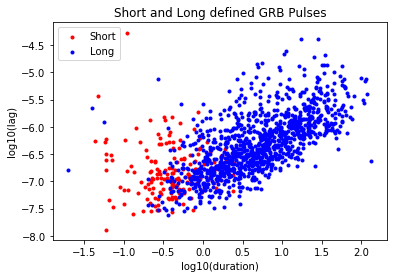

In [37]:
# plot the results
plt.figure()
plt.title( "Short and Long defined GRB Pulses")
plt.xlabel( "log10(duration)" )
plt.ylabel( "log10(lag)" )
plt.scatter( D1x, D1y, color='red', marker='.', label="Short")
plt.scatter( D2x, D2y, color='blue', marker='.', label="Long")
plt.legend()
plt.show()

## Construct the SVC Model
Using scikit learn's [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) module, construct and fit the SVC model

In [38]:
# construct the SVC model
clf = svm.SVC(kernel='linear')
# fit the SVC model
clf.fit(np.dstack((data[:,14],data[:,18]))[0], S_idx)
print( 'Intercept: '+str(clf.intercept_[0]) )
print( 'Correlation coefficients: '+str(clf.coef_[0]) )

Intercept: 0.10809000518711105
Correlation coefficients: [-3.14875548  0.15482133]


## Prep for plotting the SVC model results

In [39]:
# Build the line for the SVC results for plotting 
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-0.5, 0)
yy = a * xx - (clf.intercept_[0]) / w[1]
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

## Plot the SVC results

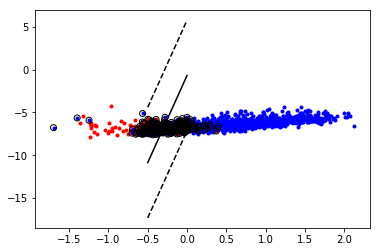

In [40]:
# plot the results
plt.figure()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')
plt.scatter( D1x, D1y, color='red', marker='.', label="Short")
plt.scatter( D2x, D2y, color='blue', marker='.', label="Long")
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], marker='o',
                facecolors='none', edgecolors='black')
plt.show()

## Confusion Matrix
Calculate the confusion martix and related `PPV`, `NPV`, `TPR`, and `TNR`

In [41]:
# define values for the confusion matrix
y_true = S_idx
y_predicted = clf.predict(np.dstack((data[:,14],data[:,18]))[0])
# calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true,y_predicted).ravel()
# calcualate PPV, NPV, TPR, and TNR from the confusion matrix
PPV = tp/(tp+fp)
NPV = tn/(tn+fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)

print('PPV: {0:0.03f}'.format(PPV))
print('NPV: {0:0.03f}'.format(NPV))
print('TPR: {0:0.03f}'.format(TPR))
print('TNR: {0:0.03f}'.format(TNR))

PPV: 0.762
NPV: 0.941
TPR: 0.626
TNR: 0.968
